In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        join_path = os.path.join(dirname, filename)

# Monet: I'm Something of a Painter Myself GAN
---

### 1 Introduction

---
#### 1.1 Overview

This dataset focuses training the machine to utilize deep learning, in order to model create Monet-like versions of given real images.

#### 1.2 Goal

The goal of this project is to utilize DCGAN, a Ganerative Adversial Network (GAN) deep learning approach, to predict a monet painting, based off of a real image input.

#### 1.2 About the Data

**1.2.1 Load The Data (Train Data)**

In [ ]:
# define the paths in which the images are stored in
monet_path = "/kaggle/input/gan-getting-started/monet_jpg/"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg/"

# display number of images in Monet and photo directories
print("Number of images in Monet directory:", len(os.listdir(monet_path)))
print("Number of images in photo directory:", len(os.listdir(photo_path)))

**1.2.2 Data Source and Citation**

**_Citation:_**
Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

The dataset that was used is called the I’m Something of a Painter Myself. It can be found [here](https://kaggle.com/competitions/gan-getting-started) page, which is cited in the link above. In this data, it provides pathology images of real and monet pictures, as well as TFREcords of each. This is to help develop monet-like paintings from real picture.

**1.3.3 Data Description**

The following datasets consists of the following dimenstions:
- `monet_jpg` - 300 Monet paintings sized 256x256 in JPEG format
- `monet_tfrec` - 300 Monet paintings sized 256x256 in TFRecord format
- `photo_jpg` - 7028 photos sized 256x256 in JPEG format
- `photo_tfrec` - 7028 photos sized 256x256 in TFRecord format


### 2 Data Cleaning

--- 
#### 2.1 Data Exploration

To understand the data, it is vital to understand what these images showcase. 

**2.1.1: Visualizing Monet Drawings**

In [ ]:
# attach image to directory
def get_image_paths(directory):
    image_paths = []
    # acquire files in which the images are located
    for root, dirs, files in os.walk(directory):
        # through each image
        for image in files:
            # iterate through every ".jpg" and ".tfec" and add directory
            if image.endswith(".jpg") or image.endswith(".tfrec"): 
                image_paths.append(os.path.join(root, image))
    return image_paths

In [ ]:
# get file paths of Monet images
monet_image_paths = get_image_paths(monet_path)

# sample size
n_images = 5

# plot images for monet peintings
plt.figure(figsize=(10, 4))

# iterate through each image 
for i in range(n_images):
    image_path = monet_image_paths[i]
    image = tf.keras.preprocessing.image.load_img(image_path,
                                                  target_size = (256, 256))
    image = tf.keras.preprocessing.image.img_to_array(image)
    # display image
    plt.subplot(2, n_images, i+1)
    plt.imshow(image.astype(np.uint8))
    plt.axis
    plt.title(f"Monet Sample {i+1}")
    
plt.tight_layout()
plt.show()

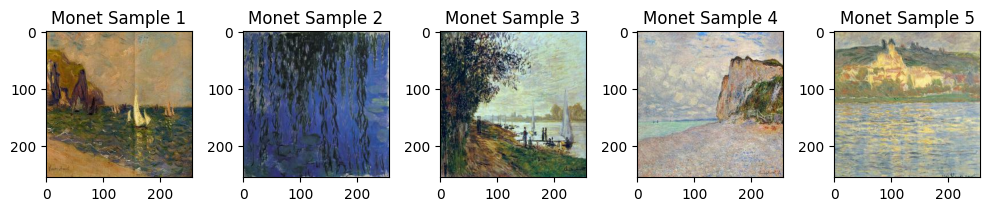

**2.1.1: Visualizing Real Photos**

In [ ]:
# get file paths of real photo images
photo_image_paths = get_image_paths(photo_path)

# sample size
n_images = 5

# plot images for photos
plt.figure(figsize=(10, 4))

# iterate through each image 
for i in range(n_images):
    image_path = photo_image_paths[i]
    image = tf.keras.preprocessing.image.load_img(image_path,
                                                  target_size = (256, 256))
    image = tf.keras.preprocessing.image.img_to_array(image)
    # display image
    plt.subplot(2, n_images, i+1)
    plt.imshow(image.astype(np.uint8))
    plt.axis
    plt.title(f"Photo Sample {i+1}")
    
plt.tight_layout()
plt.show()

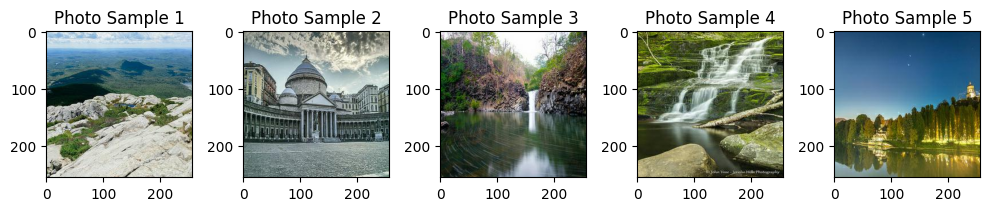

In [ ]:
range(len(photo_image_paths))

### 3 Data Pre-Processing 

---

#### 3.1 Image Data Augmentation and Scaling 
To prevent overfitting, it is useful to utilize artificially developed image data from the train data, validation data, and test data.

The first things that need to be done are: define the image generators for augmentation, make sure the data can run through the generator, then generate the data.

**3.3.1: Run TPU**

Given the state of this project, TPU is the hardware accelerators to optimize image developing models, especially in deep learning. Autotune wiill be used as a form of optimization via TenserFlow.

In [ ]:
        
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

**3.3.2: Understand TFRecord Output**

In [ ]:
monet_file_paths = get_image_paths('/kaggle/input/gan-getting-started/monet_tfrec')
photo_file_paths = get_image_paths('/kaggle/input/gan-getting-started/photo_tfrec')

print("Number of Monet TFrec Files:", len(monet_file_paths))
print("Number of Monet Image:", len(monet_image_paths))
print("Number of Photo TFrec Files:", len(photo_file_paths))
print("Number of Photo Image:", len(photo_image_paths))

The results of the TFRecord and images found that they have the dimensiosn of:
- Monet TFRecord FilesImages - 20
- Monet Images - 300
- Photo TFRecord Files - 738
- Photo Images - 7028

The information of reading a Tfrec file was found here: https://www.tensorflow.org/tutorials/load_data/tfrecord

In [ ]:
# pull a sample 
temp_filename = '/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec'

# create a df for Tfrec
tfrec_df = tf.data.TFRecordDataset([temp_filename])

# read the file; remove bytes list because it is too long
# learned from source
for raw_record in tfrec_df.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    # example prints too long of bytelist for image
    
    for key, value in example.features.feature.items():
        if key != "image":  # not "image" = okay
            print("\nFeature Key:", key)
            print("Feature Value:", value)
        elif key == "image":  # "image" = exclude decrease bytes_list feature
            print("\nFeature Key:", key)
            print("Feature Value:", value.bytes_list.value[0][:10], "...")
    

In [ ]:
# redefine the characteristics for the image; 256 x 256 and centered
def shape_image(image):
    # decode JPEG image
    image = tf.image.decode_jpeg(image, 
                                 channels = 3) # rgb
    # center pixel values to range [-1, 1]; where 256/2 -1 == [-127.5, 127]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    # maintain 256 x 256 pixel
    image = tf.reshape(image, [256, 256, 3]) 
    return image

# create a description of the features.
tfr_feat = {
    "image":      tf.io.FixedLenFeature([], tf.string),
    "target":     tf.io.FixedLenFeature([], tf.string),
    "image_name": tf.io.FixedLenFeature([], tf.string)
}

# read TFRecord function - parse using feature_description
def read_tfrec(example): 
    # parse based on the dictionary 
    ex = tf.io.parse_single_example(example, tfr_feat)
    adj_image = shape_image(ex["image"])
    return adj_image

**Observation** The key values in the images are `image`, `target`, and `image_name`.

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled = True, ordered = False):
    # create dataset
    dataset = tf.data.TFRecordDataset(filenames)
    # assign based on dictionary
    dataset = dataset.map(read_tfrec, 
                          num_parallel_calls = AUTO)
    return dataset

monet_dts = load_dataset(monet_file_paths, 
                         labeled=True).batch(1)
photo_dts = load_dataset(photo_file_paths, 
                         labeled=True).batch(1)

print("Monet Dataset:", monet_dts) # is 256 x 256; three colors RGB
print("Photo Dataset:", photo_dts) # is 256 x 256; three colors RGB

### 4 Model Architecture

---

#### 4.1 Build The DCGAN Model
The DCGAN Model is used for the purpose of  model is just


**4.1.1 Build The Discriminator**

In [ ]:
def create_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    d1 = tf.keras.layers.Conv2D(64, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(inputs)
    d2 = tf.keras.layers.Conv2D(128, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(d1)
    d3 = tf.keras.layers.Conv2D(256, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(d2)
    
    outputs = tf.keras.layers.Conv2D(1, (4, 4), 
                                   padding = "same")(d3)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

**4.1.2 Build The Generator**

In [ ]:
def create_generator():
    # reshaping the images
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # encoder
    down1 = tf.keras.layers.Conv2D(64, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(inputs)
    down2 = tf.keras.layers.Conv2D(128, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(down1)
    down3 = tf.keras.layers.Conv2D(256, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(down2)
    
    # decoder
    up1 = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(down3)
    up2 = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(up1)
    
    outputs = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides = 2, 
                                   padding = "same", 
                                   activation = "relu")(up2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)



**4.1.3 Acquire Loss for Model**

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [ ]:
def cycle_loss(real_image, cycled_image, LAMBDA = 10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

**4.1.4 Build The Optimizers**

This helps moderate the model outside of the optimization already being done by TPU

In [ ]:
# create optimizer for both the generator and discriminator
gen_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
gen_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.3)
disc_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discr_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.3)

In [ ]:
def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

In [ ]:
gen_g = create_generator()
gen_f = create_generator()
disc_x = create_discriminator()
disc_y = create_discriminator()

In [ ]:
def function_tf(real_x, real_y, gen_g, gen_f, disc_x, disc_y, 
               gen_g_optimizer, gen_f_optimizer, discr_x_optimizer, disc_y_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        # create images
        fake_y = gen_g(real_x, training = True)
        cycled_x = gen_f(fake_y, training = True)

        fake_x = gen_f(real_y, training = True)
        cycled_y = genr_g(fake_x, training = True)

        # discriminator outputs for real and fake images
        disc_real_x = disc_x(real_x, training = True)
        disc_real_y = disc_y(real_y, training = True)

        disc_fake_x = disc_x(fake_x, training = True)
        disc_fake_y = disc_y(fake_y, training = True)

        # generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # overall cycle consistency loss
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # overall generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss

        # discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # create gradiants from each generator
    gen_g_gradients = tape.gradient(total_gen_g_loss, 
                                          generator_g.trainable_variables)
    gen_f_gradients = tape.gradient(total_gen_f_loss, 
                                          generator_f.trainable_variables)

    # create gradiants from each discriminator
    disc_x_gradients = tape.gradient(disc_x_loss, 
                                     disc_x.trainable_variables)
    disc_y_gradients = tape.gradient(disc_y_loss, 
                                     disc_y.trainable_variables)

    # optimize each generator gradient
    gen_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                              generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                              generator_f.trainable_variables))

    # optimize each discriminator gradient
    discriminator_x_optimizer.apply_gradients(zip(disc_x_gradients, 
                                                  disc_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(disc_y_gradients, 
                                                  disc_y.trainable_variables))
# acquire a sample of photos for visualization
sample_photos = next(iter(photo_dts))

# sample size
n_images = 5

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    
    fig = plt.figure(figsize=(12, 12))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# Training Loop
epochs = 15
for epoch in range(epochs):
    for photo, monet in tf.data.Dataset.zip((photo_dts, monet_dts)):
        train_step(photo, monet, gen_g, gen_f, disc_x, disc_y, 
                   gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer)
    # display generated images
    if epoch % 5 == 0 or epoch == epochs - 1: 
        generate_and_save_images(generator_g, epoch, sample_photos[:NUM_SAMPLES])
        generator_g.save('generator_g_model_{}.h5'.format(epoch))

**Observation** The pictures should loop through. My TPU stopped working so I was not able to continue.

### 5 Model Analysis

---


### 6 Results

#### 6.1 Overview of Results

After creating a model, of the images overtime, it did seem promising that it could conduct generative images via DCGAN. However, due to my TPU, I was not able to run that models anymore and I have been stuck in queue. The models did display overtime changes to more like monet pictures.

#### 6.2 Discussion
Based on what I did get to see, it was very interesting and artistic of the model to say the very least.

#### 6.3 Things to Improve
I would try to take more time on this project and try to find better ways to access the TPU, since this time it did not come in my favor.

### 7 Closing

#### 7.1 Conclusion
Given what was seen for a bit, DCGAN wasa very good predictive model. I would honestly consider playing around with it more to make a actual predictive model.

#### 7.2 Sources
**7.2.1: Citations**
Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

#### 7.3 Github 
**Github Link** | https://github.com/kpnguyenco/GAN-Monet